## Toc&Browse Change Analytics


### Analytics Subject

 **overall impact for traffic:**
    * page views change for 3 areas:reference-architecture,example-scenerio,solution-ideas
 **toc clicks change**
     * count of clicks change(overall, visitors per clicks)
     * top pages for most clicks change
 **browse page change**
     * traffic
     * engagement
     * clicks behavior(count of clicks, top pags have clicks)
 
 ### Background
 **data range**
     * one or two weeks before and after Apr 4th
 
 **definition of clicks**
      * clicks the category on browse page(clicks on the bar of articles' category, having "#" keyword on linkClickEvenJason)
      * clicks the article on browse page(clicks on the picture , having "content>body" keyword)
      * clicks the toc on browse page(clicks on the picture , having "left toc" keyword)
      
     
   

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:

## test for azure connection
from azure.kusto.data.request import KustoClient, KustoConnectionStringBuilder

kcsb = KustoConnectionStringBuilder.with_aad_device_authentication("https://cgadataout.kusto.windows.net")
kc = KustoClient(kcsb)

query= """database("CustomerTouchPoint").PageView
| where Site == 'docs.microsoft.com'
| count"""
response = kc.execute("DevRelWorkArea", query)
print(response.primary_results[0][0])


To sign in, use a web browser to open the page https://microsoft.com/devicelogin and enter the code HQMGF4J35 to authenticate.
['6091038446']


In [7]:
print(response.primary_results[0][0])

['6091038446']


In [9]:

## query for running urls in below 3 areas 'solution-ideas','example-scenario','reference-architectures'
qry_dim_url_area="""
let start=datetime(2020-04-01);
let end=datetime(2020-05-01);
database('CustomerTouchPoint').PageView
| where Site == 'docs.microsoft.com'
| where IsTest!=1 and enrich_url_pg_query_string !contains 'traffic-source=cats' | invoke cluster('Cgadataout').database('Publish').ApplyTechSitesBotFilters()
| invoke database('DevRelWorkArea').FilterDocsArea('AAC')
| where StartDateTime >= start and StartDateTime < end
| extend month=getmonth(StartDateTime)
| extend stem_url = extract('^http?s://docs.microsoft.com/([^/]*)/(.*)',2,Url)
| extend stem_url= replace(@'/index$', @'/', stem_url)
| extend area=case (
Url matches regex '^https?://docs.microsoft.com/([^/]*)/azure/architecture/solution-ideas','solution-ideas',
Url matches regex '^https?://docs.microsoft.com/([^/]*)/azure/architecture/example-scenario','example-scenario',
Url matches regex '^https?://docs.microsoft.com/([^/]*)/azure/architecture/reference-architectures', 'reference-architectures','others')
| extend area = coalesce(area, 'others')
| where  not (stem_url  startswith  'assessments/')
| where area !='others'
| distinct stem_url,area
| join  kind=leftanti (
cluster('Cgadataout').database('CustomerTouchPoint').TopicMetadata
| where Site == 'docs.microsoft.com'
| where IsLive
| invoke database('DevRelWorkArea').FilterDocsAreaTopicMetadata('AAC')
| extend stem_url = extract('^http?s://docs.microsoft.com/([^/]*)/(.*)',2,LiveUrl)
| where TopicType in ('landing-page','guide')
| distinct  stem_url,TopicType
) on stem_url
| distinct stem_url,area
"""
response = kc.execute("DevRelWorkArea", qry_dim_url_area)
dim_url_area=pd.DataFrame(response.primary_results[0],columns=["stem_url","area"])
dim_url_area.head(10)


,stem_url,area
0,azure/architecture/reference-architectures/hyb...,reference-architectures
1,azure/architecture/example-scenario/data/fraud...,example-scenario
2,azure/architecture/reference-architectures/ai/...,reference-architectures
3,azure/architecture/solution-ideas/articles/hyb...,solution-ideas
4,azure/architecture/solution-ideas/articles/dis...,solution-ideas
5,azure/architecture/solution-ideas/articles/dem...,solution-ideas
6,azure/architecture/solution-ideas/articles/rea...,solution-ideas
7,azure/architecture/solution-ideas/articles/int...,solution-ideas
8,azure/architecture/solution-ideas/articles/dat...,solution-ideas
9,azure/architecture/solution-ideas/articles/sha...,solution-ideas


In [15]:

## query for runing page views for all articles 
qry_url_pv="""
let start=datetime(2020-03-15);
let end=datetime(2020-05-01);
database('CustomerTouchPoint').PageView
| where Site == 'docs.microsoft.com'
| where IsTest!=1 and enrich_url_pg_query_string !contains 'traffic-source=cats' | invoke cluster('Cgadataout').database('Publish').ApplyTechSitesBotFilters()
| invoke database('DevRelWorkArea').FilterDocsArea('AAC')
| where StartDateTime >= start and StartDateTime < end
| extend month=getmonth(StartDateTime)
| extend stem_url = extract("^http?s://docs.microsoft.com/([^/]*)/(.*)",2,Url)
| extend stem_url= replace(@'/index$', @'/', stem_url)
| summarize pv=dcount(PageViewId,2) by stem_url,day=startofday(StartDateTime)
"""
response = kc.execute("DevRelWorkArea", qry_url_pv)
url_pv=pd.DataFrame(response.primary_results[0],columns=["stem_url","day","pv"])
url_pv.day=pd.to_datetime(url_pv.day)
url_pv.head(10)



,stem_url,day,pv
0,azure/architecture/patterns/cqrs,2020-03-29 00:00:00+00:00,349
1,azure/architecture/,2020-03-29 00:00:00+00:00,1270
2,azure/architecture/data-guide/scenarios/data-t...,2020-03-29 00:00:00+00:00,25
3,azure/architecture/microservices/design/inters...,2020-03-29 00:00:00+00:00,81
4,azure/architecture/patterns/queue-based-load-l...,2020-03-29 00:00:00+00:00,48
5,azure/architecture/topics/high-performance-com...,2020-03-29 00:00:00+00:00,68
6,azure/architecture/patterns/,2020-03-29 00:00:00+00:00,488
7,azure/architecture/patterns/category/security,2020-03-29 00:00:00+00:00,25
8,azure/architecture/multitenant-identity/claims,2020-03-29 00:00:00+00:00,26
9,azure/cloud-adoption-framework/ready/azure-set...,2020-03-29 00:00:00+00:00,353


In [20]:

## combine traffic and area
url_pv_area=pd.merge(dim_url_area,url_pv,on="stem_url")
url_pv_area.head()



,stem_url,area,day,pv
0,azure/architecture/reference-architectures/hyb...,reference-architectures,2020-03-29 00:00:00+00:00,24
1,azure/architecture/reference-architectures/hyb...,reference-architectures,2020-03-18 00:00:00+00:00,53
2,azure/architecture/reference-architectures/hyb...,reference-architectures,2020-03-19 00:00:00+00:00,34
3,azure/architecture/reference-architectures/hyb...,reference-architectures,2020-04-11 00:00:00+00:00,42
4,azure/architecture/reference-architectures/hyb...,reference-architectures,2020-04-23 00:00:00+00:00,135


In [38]:

## grouy by day and area
tmp_pv_area=url_pv_area[['pv','day','area']].groupby(['day','area'],as_index=False).sum()
tmp_pv_area.head()

,day,area,pv
0,2020-03-15 00:00:00+00:00,example-scenario,453
1,2020-03-15 00:00:00+00:00,reference-architectures,2517
2,2020-03-15 00:00:00+00:00,solution-ideas,1363
3,2020-03-16 00:00:00+00:00,example-scenario,1552
4,2020-03-16 00:00:00+00:00,reference-architectures,7124


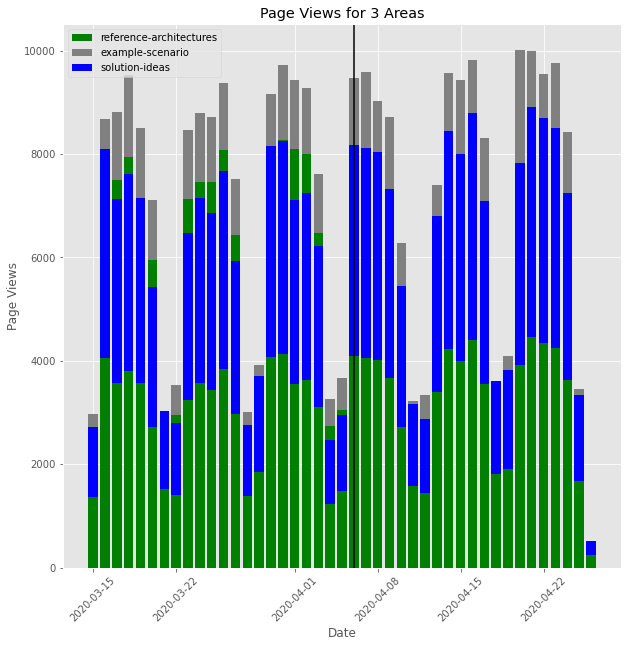

In [40]:
 
 ## bar chart for 3 areas traffic
fig=plt.figure(figsize=(10,10))
ax=fig.add_subplot(111)
plt.style.use('ggplot')

url_pv_area_ref=tmp_pv_area.loc[tmp_pv_area.area=="reference-architectures",]
ax.bar(x=url_pv_area_ref.day,height=url_pv_area_ref.pv,label="reference-architectures",color="green")
url_pv_area_exa=tmp_pv_area.loc[tmp_pv_area.area=="example-scenario",]
ax.bar(x=url_pv_area_exa.day,height=url_pv_area_exa.pv,bottom=url_pv_area_ref.pv,label="example-scenario",color='grey')
url_pv_area_sol=tmp_pv_area.loc[tmp_pv_area.area=="solution-ideas",]
ax.bar(x=url_pv_area_sol.day,height=url_pv_area_sol.pv,bottom=url_pv_area_sol.pv,label="solution-ideas",color='blue')

plt.axvline(np.datetime64('2020-04-06'),color="black")
plt.title("Page Views for 3 Areas")
plt.xlabel("Date")
plt.ylabel("Page Views")
plt.xticks(rotation=45)
plt.legend()
plt.show()


No handles with labels found to put in legend.


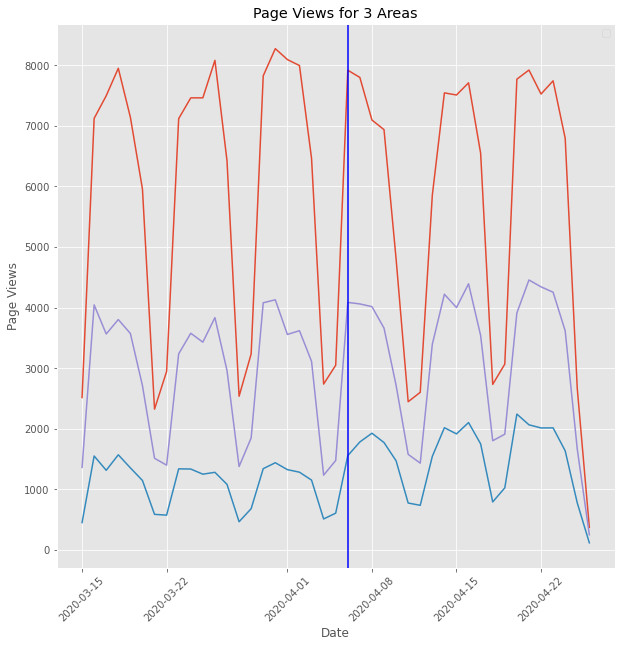

In [44]:

## line chart for 3 areas
fig=plt.figure(figsize=(10,10))
ax=fig.add_subplot(111)
plt.style.use("ggplot")


area_ls=['reference-architectures','example-scenario','solution-ideas']
for i in area_ls:
    tmp_pv_area_subset=tmp_pv_area.loc[tmp_pv_area.area==i,]
    ax.plot(tmp_pv_area_subset.day,tmp_pv_area_subset.pv,label=i)

plt.axvline(np.datetime64('2020-04-06'),color="blue")
plt.title("Page Views for 3 Areas")
plt.xticks(rotation=45)
plt.xlabel("Date")
plt.ylabel("Page Views")
plt.legend()
plt.show()


In [64]:

## uv and pv clicks toc for 3 areas
qry_toc_clicks_area="""
// have clicks on toc of architectures folder
//let start=datetime(2020-03-15);
//let end=datetime(2020-05-01);
database('CustomerTouchPoint').PageView
| where Site == 'docs.microsoft.com'
| where IsTest!=1 and enrich_url_pg_query_string !contains 'traffic-source=cats' | invoke cluster('Cgadataout').database('Publish').ApplyTechSitesBotFilters()
| invoke database('DevRelWorkArea').FilterDocsArea('AAC')
| where StartDateTime >= start and StartDateTime < end
| extend month=getmonth(StartDateTime)
| extend stem_url = extract('^http?s://docs.microsoft.com/([^/]*)/(.*)',2,Url)
| extend stem_url= replace(@'/index$', @'/', stem_url)
| where LinkClickEvents ==1
| where ( LinkClickEventsJson  contains 'left toc')  // means have toc clicks
| mv-expand target_url_Json
| extend tar_stem_url = extract('^http?s://docs.microsoft.com/([^/]*)/(.*)',2,tostring(target_url_Json))
| extend tar_stem_url= replace(@'/index$', @'/', tar_stem_url)
| project  PageViewId,VisitorId,tar_stem_url 
| join  kind=inner (
database('CustomerTouchPoint').PageView
| where Site == 'docs.microsoft.com'
| where IsTest!=1 and enrich_url_pg_query_string !contains 'traffic-source=cats' | invoke cluster('Cgadataout').database('Publish').ApplyTechSitesBotFilters()
| invoke database('DevRelWorkArea').FilterDocsArea('AAC')
| where StartDateTime >= start and StartDateTime < end
| extend month=getmonth(StartDateTime)
| extend stem_url = extract('^http?s://docs.microsoft.com/([^/]*)/(.*)',2,Url)
| extend stem_url= replace(@'/index$', @'/', stem_url)
| extend area=case (
Url matches regex '^https?://docs.microsoft.com/([^/]*)/azure/architecture/solution-ideas','solution-ideas',
Url matches regex '^https?://docs.microsoft.com/([^/]*)/azure/architecture/example-scenario','example-scenario',
Url matches regex '^https?://docs.microsoft.com/([^/]*)/azure/architecture/reference-architectures', 'reference-architectures','others')
| extend area = coalesce(area, 'others')
| where  not (stem_url  startswith  'assessments/')
| where area !='others'
| distinct stem_url,area
| join  kind=leftanti (
cluster('Cgadataout').database('CustomerTouchPoint').TopicMetadata
| where Site == 'docs.microsoft.com'
| where IsLive
| invoke database('DevRelWorkArea').FilterDocsAreaTopicMetadata('AAC')
| extend stem_url = extract('^http?s://docs.microsoft.com/([^/]*)/(.*)',2,LiveUrl)
| where TopicType in ('landing-page','guide')
| distinct  stem_url
) on stem_url
) on $left.tar_stem_url==$right.stem_url //target stem_url is in list of architectures folder
| summarize dcount(PageViewId,2),dcount(VisitorId,2) by area
"""

## 7days before adjustment
qry_date_before="""
let start=datetime(2020-03-30);
let end=datetime(2020-04-06);
"""
response = kc.execute("DevRelWorkArea", qry_date_before+qry_toc_clicks_area)
toc_clicks_area_before=pd.DataFrame(response.primary_results[0],columns=["area","pv","uv"])
toc_clicks_area_before

## 7days after adjustment
qry_date_after="""
let start=datetime(2020-04-07);
let end=datetime(2020-04-14);
"""
response = kc.execute("DevRelWorkArea", qry_date_after+qry_toc_clicks_area)
toc_clicks_area_after=pd.DataFrame(response.primary_results[0],columns=["area","pv","uv"])
toc_clicks_area_after


,area,pv,uv
0,reference-architectures,7420,2974
1,example-scenario,3275,1837
2,solution-ideas,7666,2679


In [65]:

## merge before and after dataframe
toc_clicks_area_before["flg"]="before"
toc_clicks_area_after["flg"]="after"
comp_toc_clicks_area=pd.concat([toc_clicks_area_before,toc_clicks_area_after],axis=0)



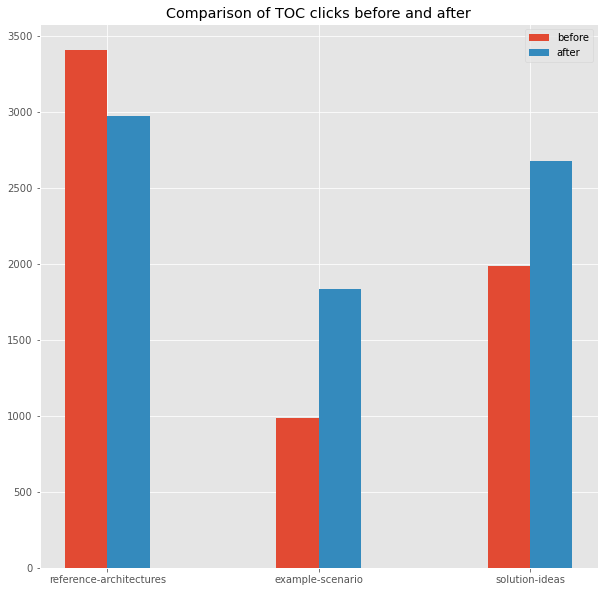

In [66]:
## bar chart for before and after comp for area's overall UV
fig=plt.figure(figsize=(10,10))
ax=fig.add_subplot(111)
#plt.style.use("ggplot")

x=range(3)
ax.bar(x,toc_clicks_area_before.uv,width=0.2,label="before")
ax.bar([i+0.2 for i in x],toc_clicks_area_after.uv,width=0.2,label="after")

plt.xticks([i + 0.1 for i in x], toc_clicks_area_before.area)
plt.title("Comparison of TOC clicks before and after")
plt.legend()
plt.show()


#comp_toc_clicks_area.loc[:,["area","uv","flg"]].plot(kind="bar")


In [12]:

## overall traffic for 3 areas

qry_area_traf="""
// total traffic for 3 areas
database('CustomerTouchPoint').PageView
| where Site == 'docs.microsoft.com'
| where IsTest!=1 and enrich_url_pg_query_string !contains 'traffic-source=cats' | invoke cluster('Cgadataout').database('Publish').ApplyTechSitesBotFilters()
| invoke database('DevRelWorkArea').FilterDocsArea('AAC')
| where StartDateTime >= start and StartDateTime < end
| extend month=getmonth(StartDateTime)
| extend stem_url = extract('^http?s://docs.microsoft.com/([^/]*)/(.*)',2,Url)
| extend stem_url= replace(@'/index$', @'/', stem_url)
| mv-expand target_url_Json
| extend tar_stem_url = extract('^http?s://docs.microsoft.com/([^/]*)/(.*)',2,tostring(target_url_Json))
| extend tar_stem_url= replace(@'/index$', @'/', tar_stem_url)
| extend target_url=tostring(target_url_Json) 
| extend area=case (
target_url matches regex '^https?://docs.microsoft.com/([^/]*)/azure/architecture/solution-ideas','solution-ideas',
target_url matches regex '^https?://docs.microsoft.com/([^/]*)/azure/architecture/example-scenario','example-scenario',
target_url matches regex '^https?://docs.microsoft.com/([^/]*)/azure/architecture/reference-architectures', 'reference-architectures','others')
| extend area = coalesce(area, 'others')
| where area !='others'
| where  not (stem_url  startswith  'assessments/')
| summarize uv=dcount(VisitorId,2),pv=dcount(PageViewId) by area
"""

## 7days before adjustment
qry_date_before="""
let start=datetime(2020-03-30);
let end=datetime(2020-04-06);
"""
response = kc.execute("DevRelWorkArea", qry_date_before+qry_area_traf)
toc_traf_area_before=pd.DataFrame(response.primary_results[0],columns=["area","uv","pv"])
toc_traf_area_before

## 7days after adjustment
qry_date_after="""
let start=datetime(2020-04-07);
let end=datetime(2020-04-14);
"""
response = kc.execute("DevRelWorkArea", qry_date_after+qry_area_traf)
toc_traf_area_after=pd.DataFrame(response.primary_results[0],columns=["area","uv","pv"])
toc_traf_area_after





,area,uv,pv
0,reference-architectures,5288,12558
1,example-scenario,2938,5327
2,solution-ideas,4394,12263


In [13]:
## CTR for 3 areas, for before and after
merge_before=pd.merge(toc_clicks_area_before,toc_traf_area_before,on="area")
merge_before.rename(columns={"pv_y":"overall_pv","uv_y":"overall_uv","uv_x":"clicks_uv","pv_x":"clicks_pv"},inplace=True)
merge_before['perFromTOC']=merge_before['clicks_uv']/merge_before['overall_uv']

merge_after=pd.merge(toc_clicks_area_after,toc_traf_area_after,on="area")
merge_after.rename(columns={"pv_y":"overall_pv","uv_y":"overall_uv","uv_x":"clicks_uv","pv_x":"clicks_pv"},inplace=True)
merge_after['perFromTOC']=merge_after['clicks_uv']/merge_after['overall_uv']


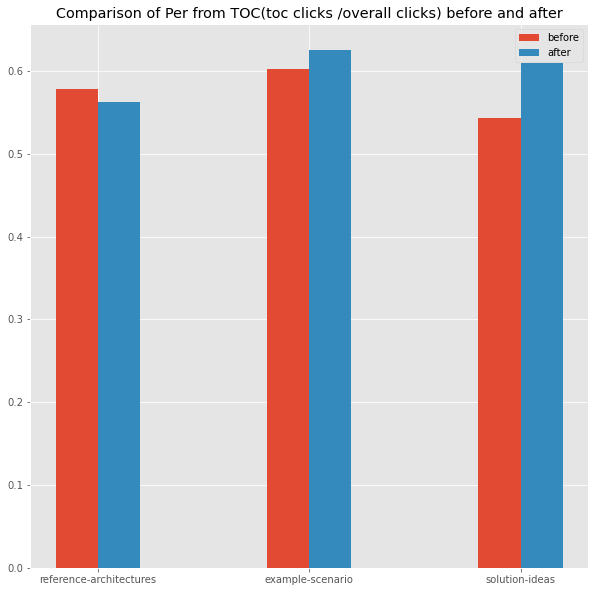

In [62]:
## bar chart for before and after comp for area's bar plot from toc
fig=plt.figure(figsize=(10,10))
ax=fig.add_subplot(111)
#plt.style.use("ggplot")

x=range(3)
ax.bar(x,merge_before.perFromTOC,width=0.2,label="before")
ax.bar([i+0.2 for i in x],merge_after.perFromTOC,width=0.2,label="after")

plt.xticks([i + 0.1 for i in x], toc_clicks_area_before.area)
plt.title("Comparison of Per from TOC(toc clicks /overall clicks) before and after")
plt.legend()
plt.show()



In [67]:
## toc clicks of url level before and after
qry_url_clicks="""
// have clicks on toc of architectures folder
//let start=datetime(2020-04-07);
//let end=datetime(2020-05-01);
database('CustomerTouchPoint').PageView
| where Site == 'docs.microsoft.com'
| where IsTest!=1 and enrich_url_pg_query_string !contains 'traffic-source=cats' | invoke cluster('Cgadataout').database('Publish').ApplyTechSitesBotFilters()
| invoke database('DevRelWorkArea').FilterDocsArea('AAC')
| where StartDateTime >= start and StartDateTime < end
| extend month=getmonth(StartDateTime)
| extend stem_url = extract('^http?s://docs.microsoft.com/([^/]*)/(.*)',2,Url)
| extend stem_url= replace(@'/index$', @'/', stem_url)
| mv-expand target_url_Json
| extend tar_stem_url = extract('^http?s://docs.microsoft.com/([^/]*)/(.*)',2,tostring(target_url_Json))
| extend tar_stem_url= replace(@'/index$', @'/', tar_stem_url)
| extend target_url=tostring(target_url_Json) 
| extend area=case (
target_url matches regex '^https?://docs.microsoft.com/([^/]*)/azure/architecture/solution-ideas','solution-ideas',
target_url matches regex '^https?://docs.microsoft.com/([^/]*)/azure/architecture/example-scenario','example-scenario',
target_url matches regex '^https?://docs.microsoft.com/([^/]*)/azure/architecture/reference-architectures', 'reference-architectures','others')
| extend area = coalesce(area, 'others')
| where area !='others'
| where  not (stem_url  startswith  'assessments/')
| where LinkClickEvents ==1
| where ( LinkClickEventsJson  contains "left toc") 
| join  kind=leftanti (
cluster('Cgadataout').database('CustomerTouchPoint').TopicMetadata
| where Site == 'docs.microsoft.com'
| where IsLive
| invoke database('DevRelWorkArea').FilterDocsAreaTopicMetadata('AAC')
| extend stem_url = extract('^http?s://docs.microsoft.com/([^/]*)/(.*)',2,LiveUrl)
| where TopicType in ('landing-page','guide')
| distinct  stem_url
) on $left.tar_stem_url==$right.stem_url
| summarize pv=dcount(PageViewId,2),uv=dcount(VisitorId,2) by tar_stem_url,area
"""


## 7days before adjustment
qry_date_before="""
let start=datetime(2020-03-30);
let end=datetime(2020-04-06);
"""

## 7days after adjustment
qry_date_after="""
let start=datetime(2020-04-07);
let end=datetime(2020-04-14);
"""
response = kc.execute("DevRelWorkArea", qry_date_before+qry_url_clicks)
qry_url_clicks_before=pd.DataFrame(response.primary_results[0],columns=["tar_stem_url","area","pv","uv"])
qry_url_clicks_before


response = kc.execute("DevRelWorkArea", qry_date_after+qry_url_clicks)
qry_url_clicks_after=pd.DataFrame(response.primary_results[0],columns=["tar_stem_url","area","pv","uv"])
qry_url_clicks_after

,tar_stem_url,area,pv,uv
0,azure/architecture/reference-architectures/hybrid-networking/vnet-peering,reference-architectures,349,305
1,azure/architecture/example-scenario/data/fraud-detection,example-scenario,177,167
2,azure/architecture/reference-architectures/ai/mlops-python,reference-architectures,40,36
3,azure/architecture/solution-ideas/articles/hybrid-connectivity,solution-ideas,169,136
4,azure/architecture/solution-ideas/articles/disaster-recovery-enterprise-scale-dr,solution-ideas,49,41
5,azure/architecture/solution-ideas/articles/demand-forecasting,solution-ideas,66,60
6,azure/architecture/solution-ideas/articles/real-time-analytics,solution-ideas,82,73
7,azure/architecture/solution-ideas/articles/interactive-voice-response-bot,solution-ideas,19,17
8,azure/architecture/solution-ideas/articles/data-cache-with-redis-cache,solution-ideas,41,39
9,azure/architecture/solution-ideas/articles/sharepoint-farm-office-365,solution-ideas,36,34


In [75]:
## top target pages for toc clicks, before and after
#qry_url_clicks_before.sort_values(by="uv",ascending=False,inplace=True)
#qry_url_clicks_after.sort_values(by="uv",ascending=False,inplace=True)
#显示所有列
pd.set_option('display.max_columns', None)
#显示所有行
pd.set_option('display.max_rows', None)
#设置value的显示长度为100，默认为50
pd.set_option('max_colwidth',100)

qry_url_clicks_before["suburl"]=qry_url_clicks_before.tar_stem_url.apply(lambda x: x[18:])
qry_url_clicks_after["suburl"]=qry_url_clicks_after.tar_stem_url.apply(lambda x: x[18:])


print(qry_url_clicks_before.groupby('suburl')['pv'].sum().sort_values(ascending=False).head(20))
print(qry_url_clicks_after.groupby('suburl')['pv'].sum().sort_values(ascending=False).head(20))
#qry_url_clicks_before[["suburl","pv"]].head(10)
#qry_url_clicks_after[["suburl","pv"]].head(10)


suburl
/reference-architectures/hybrid-networking/shared-services                      468
/reference-architectures/app-service-web-app/basic-web-app                      425
/reference-architectures/hybrid-networking/vpn                                  408
/reference-architectures/hybrid-networking/hub-spoke                            401
/reference-architectures/data/enterprise-bi-synapse                             380
/reference-architectures/microservices/aks                                      375
/reference-architectures/app-service-web-app/scalable-web-app                   326
/reference-architectures/hybrid-networking/expressroute                         308
/reference-architectures/data/enterprise-bi-adf                                 298
/reference-architectures/identity/                                              268
/solution-ideas/articles/advanced-analytics-on-big-data                         263
/reference-architectures/enterprise-integration/basic-enterprise-inte

In [69]:
## get sub-url, remove the azure/architecure

#显示所有列
pd.set_option('display.max_columns', None)
#显示所有行
pd.set_option('display.max_rows', None)
#设置value的显示长度为100，默认为50
pd.set_option('max_colwidth',100)

qry_url_clicks_before["suburl"]=qry_url_clicks_before.tar_stem_url.apply(lambda x: x[18:])
qry_url_clicks_after["suburl"]=qry_url_clicks_after.tar_stem_url.apply(lambda x: x[18:])
qry_url_clicks_before[["suburl","uv"]].head(10)
qry_url_clicks_after[["suburl","uv"]].head(10)
#qry_url_clicks_before[["pv",'suburl']].head(10).plot(x="suburl",y="pv",kind='bar')
#plt.xticks(rotation=45)




,suburl,uv
0,/reference-architectures/hybrid-networking/vnet-peering,305
1,/example-scenario/data/fraud-detection,167
2,/reference-architectures/ai/mlops-python,36
3,/solution-ideas/articles/hybrid-connectivity,136
4,/solution-ideas/articles/disaster-recovery-enterprise-scale-dr,41
5,/solution-ideas/articles/demand-forecasting,60
6,/solution-ideas/articles/real-time-analytics,73
7,/solution-ideas/articles/interactive-voice-response-bot,17
8,/solution-ideas/articles/data-cache-with-redis-cache,39
9,/solution-ideas/articles/sharepoint-farm-office-365,34


In [20]:
## which page have most clicks,calculate CTR
qry_source_clicks="""
// which page have most clicks
//let start=datetime(2020-04-07);
//let end=datetime(2020-05-01);
database('CustomerTouchPoint').PageView
| where Site == 'docs.microsoft.com'
| where IsTest!=1 and enrich_url_pg_query_string !contains 'traffic-source=cats' | invoke cluster('Cgadataout').database('Publish').ApplyTechSitesBotFilters()
| invoke database('DevRelWorkArea').FilterDocsArea('AAC')
| where StartDateTime >= start and StartDateTime < end
| extend month=getmonth(StartDateTime)
| extend stem_url = extract('^http?s://docs.microsoft.com/([^/]*)/(.*)',2,Url)
| extend stem_url= replace(@'/index$', @'/', stem_url)
| mv-expand target_url_Json
| extend tar_stem_url = extract('^http?s://docs.microsoft.com/([^/]*)/(.*)',2,tostring(target_url_Json))
| extend tar_stem_url= replace(@'/index$', @'/', tar_stem_url)
| extend target_url=tostring(target_url_Json) 
| extend area=case (
target_url matches regex '^https?://docs.microsoft.com/([^/]*)/azure/architecture/solution-ideas','solution-ideas',
target_url matches regex '^https?://docs.microsoft.com/([^/]*)/azure/architecture/example-scenario','example-scenario',
target_url matches regex '^https?://docs.microsoft.com/([^/]*)/azure/architecture/reference-architectures', 'reference-architectures','others')
| extend area = coalesce(area, 'others')
| where area !='others'
| where  not (stem_url  startswith  'assessments/')
| where LinkClickEvents ==1
| where ( LinkClickEventsJson  contains "toc") 
| join  kind=leftanti (
cluster('Cgadataout').database('CustomerTouchPoint').TopicMetadata
| where Site == 'docs.microsoft.com'
| where IsLive
| invoke database('DevRelWorkArea').FilterDocsAreaTopicMetadata('AAC')
| extend stem_url = extract('^http?s://docs.microsoft.com/([^/]*)/(.*)',2,LiveUrl)
| where TopicType in ('landing-page','guide')
| distinct  stem_url
) on $left.tar_stem_url==$right.stem_url
| summarize uv=dcount(VisitorId,2) by tar_stem_url,stem_url
"""

qry_date="""
let start=datetime(2020-04-07);
let end=datetime(2020-05-01);
"""
response = kc.execute("DevRelWorkArea", qry_date+qry_source_clicks)
source_clicks=pd.DataFrame(response.primary_results[0],columns=["tar_stem_url","area","uv"])
source_clicks.sort_values(by="uv",ascending=False,inplace=True)
source_clicks.head(10)


,tar_stem_url,area,uv
6659,azure/architecture/reference-architectures/dmz/secure-vnet-dmz,azure/architecture/reference-architectures/hybrid-networking/hub-spoke,281
7075,azure/architecture/reference-architectures/identity/,azure/architecture/reference-architectures/identity/azure-ad,265
4767,azure/architecture/reference-architectures/dmz/nva-ha,azure/architecture/reference-architectures/hybrid-networking/vnet-peering,240
3087,azure/architecture/reference-architectures/hybrid-networking/hub-spoke,azure/architecture/reference-architectures/dmz/secure-vnet-dmz,223
7367,azure/architecture/example-scenario/apps/ecommerce-scenario,azure/architecture/reference-architectures/app-service-web-app/basic-web-app,215
6142,azure/architecture/reference-architectures/data/enterprise-bi-synapse,azure/architecture/reference-architectures/enterprise-integration/basic-enterprise-integration,205
928,azure/architecture/solution-ideas/articles/anomaly-detection-in-real-time-data-streams,azure/architecture/solution-ideas/articles/advanced-analytics-on-big-data,183
4236,azure/architecture/reference-architectures/hybrid-networking/expressroute-vpn-failover,azure/architecture/reference-architectures/hybrid-networking/,179
5122,azure/architecture/solution-ideas/articles/scalable-web-apps,azure/architecture/reference-architectures/app-service-web-app/scalable-web-app,167
7152,azure/architecture/example-scenario/apps/fully-managed-secure-apps,azure/architecture/example-scenario/data/fraud-detection,160


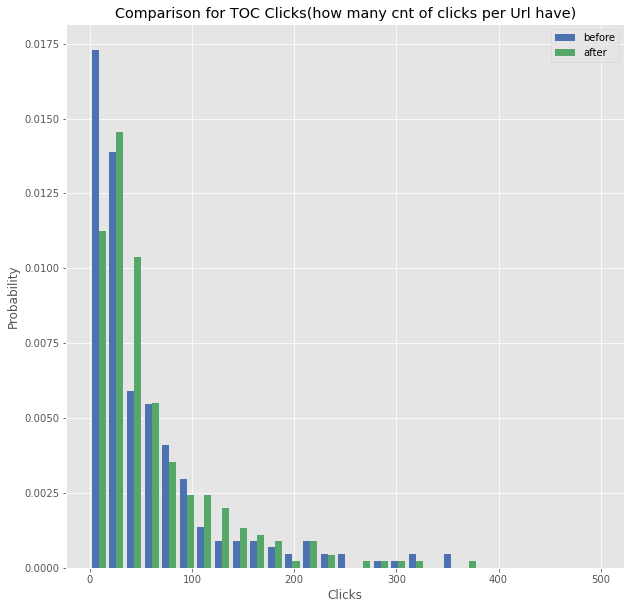

In [74]:

## hist for clicks' UV before and after 
fig=plt.figure(figsize=(10,10))
ax=fig.add_subplot(111)
plt.style.use('seaborn-deep')

x=qry_url_clicks_before.uv
y=qry_url_clicks_after.uv
bins = np.linspace(0, 500, 30)


plt.hist([x, y], bins, label=['before', 'after'],density=True)
plt.xlabel("Clicks")
plt.ylabel("Probability")
plt.title("Comparison for TOC Clicks(how many cnt of clicks per Url have)")
plt.legend(loc='upper right')
plt.show()


In [22]:



## browse and 3 pages' page traffic and 
qry_daily_traffic_arc="""
//let start=datetime(2020-04-01);
//let end=datetime(2020-05-01);
database('CustomerTouchPoint').PageView
| where Site == 'docs.microsoft.com'
| where IsTest!=1 and enrich_url_pg_query_string !contains 'traffic-source=cats' | invoke cluster('Cgadataout').database('Publish').ApplyTechSitesBotFilters()
| invoke database('DevRelWorkArea').FilterDocsArea('AAC')
| where StartDateTime >= start and StartDateTime < end
| extend month=getmonth(StartDateTime)
| extend stem_url = extract('^http?s://docs.microsoft.com/([^/]*)/(.*)',2,Url)
| extend stem_url= replace(@'/index$', @'/', stem_url)
| where Url matches regex @'^https?://docs.microsoft.com/en-us/azure/architecture/browse/' or  Url matches regex @'^https?://docs.microsoft.com/en-us/azure/architecture/architectures/'
| extend  referrerUrl=strcat( Referrer_uri_stem,ReferrerDomain)
| extend day=startofday(StartDateTime)
| project PageViewId,day,stem_url,VisitorId
| summarize pv=dcount(PageViewId,2),uv=dcount(VisitorId,2) by day,stem_url
| sort by stem_url,day
"""

## 7days before adjustment
qry_date="""
let start=datetime(2020-03-30);
let end=datetime(2020-04-14);
"""

response = kc.execute("DevRelWorkArea", qry_date+qry_daily_traffic_arc)
daily_traffic_arc=pd.DataFrame(response.primary_results[0],columns=["day","stem_url","pv","uv"])
daily_traffic_arc.head(10)
daily_traffic_arc["suburl"]=daily_traffic_arc.stem_url.apply(lambda x: x[18:]) ## remove azure/architecurtes
daily_traffic_arc=daily_traffic_arc.iloc[:,[4,0,2,3,1]]
#daily_traffic_arc.day=pd.to_datetime(daily_traffic_arc.day)
daily_traffic_arc.info()

#remove time zone
daily_traffic_arc.day=pd.to_datetime(daily_traffic_arc['day']).apply(lambda x: x.replace(tzinfo=None))

## subset for 3 urls and browse page
daily_traffic_arc_before=daily_traffic_arc[daily_traffic_arc.suburl!="/browse/"]
daily_traffic_arc_after=daily_traffic_arc[daily_traffic_arc.suburl=="/browse/"]

## get subset for 3 urls before 4/6
daily_traffic_arc_before=daily_traffic_arc_before[daily_traffic_arc_before.day<np.datetime64('2020-04-06')]

## get subset for 3 urls before 4/6
daily_traffic_arc_after=daily_traffic_arc_after[daily_traffic_arc_after.day>np.datetime64('2020-04-06')]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49 entries, 0 to 48
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype                  
---  ------    --------------  -----                  
 0   suburl    49 non-null     object                 
 1   day       49 non-null     datetime64[ns, tzutc()]
 2   pv        49 non-null     int64                  
 3   uv        49 non-null     int64                  
 4   stem_url  49 non-null     object                 
dtypes: datetime64[ns, tzutc()](1), int64(2), object(2)
memory usage: 2.0+ KB


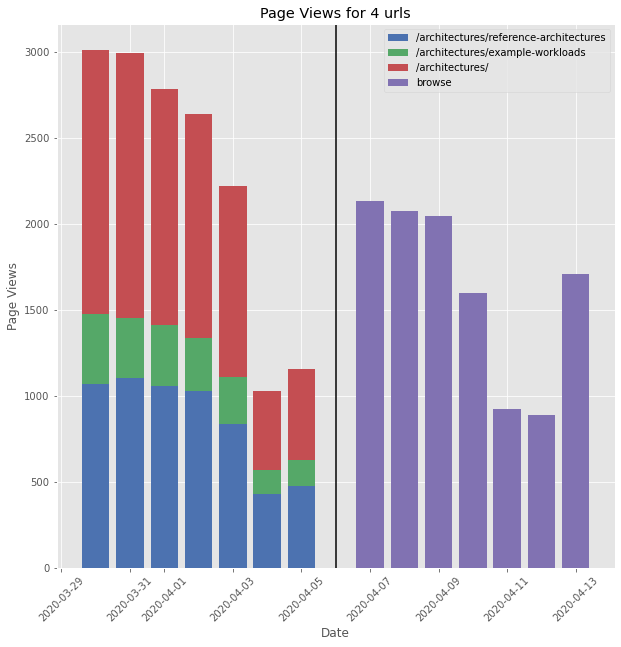

In [23]:

## barchart for 4 urls
 ## bar chart for 3 areas traffic
fig=plt.figure(figsize=(10,10))
ax=fig.add_subplot(111)
plt.style.use('ggplot')

url_ls=daily_traffic_arc_before.suburl.unique().tolist()
bot=np.array([0]*7)

for url in url_ls:
    daily_traffic_arc_before_tmp=daily_traffic_arc_before[daily_traffic_arc_before.suburl==url]
  #  ax.plot(daily_traffic_arc_before_tmp.day,daily_traffic_arc_before_tmp.pv)
    ax.bar(x=daily_traffic_arc_before_tmp.day,height=daily_traffic_arc_before_tmp.pv,bottom=bot,label=url)
    bot+=np.array(daily_traffic_arc_before_tmp.pv)

ax.bar(daily_traffic_arc_after.day,daily_traffic_arc_after.pv,label="browse")

plt.axvline(np.datetime64('2020-04-06'),color="black")
plt.title("Page Views for 4 urls")
plt.xlabel("Date")
plt.ylabel("Page Views")
plt.xticks(rotation=45)
plt.legend()
plt.show()







In [59]:
## long term trend for 3 urls
## long term daily traffic
qry_daily_traf="""
let start=datetime(2019-01-01);
let end=datetime(2020-04-06);
database('CustomerTouchPoint').PageView
| where Site == 'docs.microsoft.com'
| where IsTest!=1 and enrich_url_pg_query_string !contains 'traffic-source=cats' | invoke cluster('Cgadataout').database('Publish').ApplyTechSitesBotFilters()
| invoke database('DevRelWorkArea').FilterDocsArea('AAC')
| where StartDateTime >= start and StartDateTime < end
| extend month=getmonth(StartDateTime)
| extend stem_url = extract('^http?s://docs.microsoft.com/([^/]*)/(.*)',2,Url)
| extend stem_url= replace(@'/index$', @'/', stem_url)
| where  Url matches regex @'^https?://docs.microsoft.com/en-us/azure/architecture/architectures/'
| summarize pv=dcount(PageViewId,2),uv=dcount(VisitorId,2) by day=startofday(StartDateTime)
 """
response = kc.execute("DevRelWorkArea",qry_daily_traf)
daily_traf=pd.DataFrame(response.primary_results[0],columns=['day','pv','uv'])
daily_traf.head(10)
daily_traf.day=pd.to_datetime(daily_traf.day)
daily_traf.info()
daily_traf.sort_values(by="day",inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype                  
---  ------  --------------  -----                  
 0   day     110 non-null    datetime64[ns, tzutc()]
 1   pv      110 non-null    int64                  
 2   uv      110 non-null    int64                  
dtypes: datetime64[ns, tzutc()](1), int64(2)
memory usage: 2.7 KB


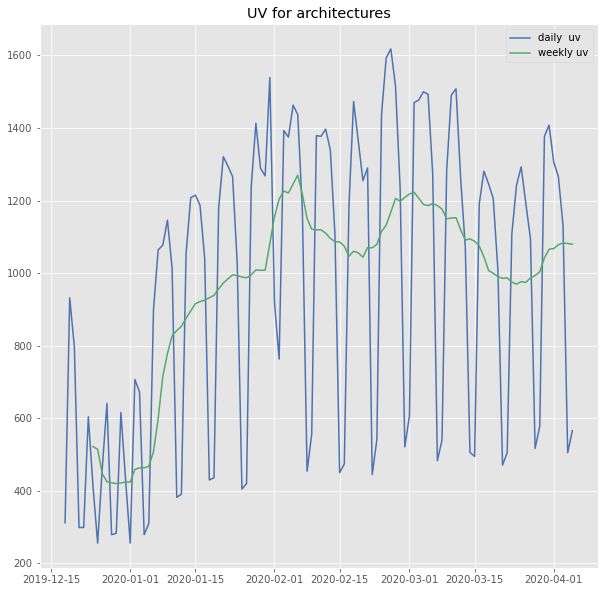

In [76]:

#plot long term trend

fig=plt.figure(figsize=(10,10))
ax=fig.add_subplot(111)


daily_traf_subset=daily_traf.loc[:,['day','uv']]
#daily_traf_subset.day=pd.to_datetime(daily_traf_subset).apply(lambda x: x.replace(tzinfo=None))
#daily_traf.set_index('day',inplace=True)

#daily_traf_subset=daily_traf_subset.reset_index()
ax.plot(daily_traf_subset.day,daily_traf_subset.uv,label="daily  uv")
ax.plot(daily_traf_subset.day,daily_traf_subset.uv.rolling(7).mean(),label="weekly uv")


#weekly=daily_traf_subset.resample('W').sum()
#weekly.plot()
plt.title("UV for architectures")
plt.legend()
plt.show()

In [25]:

## click the title

qry_title_clicks="""
//let start=datetime(2020-04-07);
//let end=datetime(2020-04-14);
database('CustomerTouchPoint').PageView
| where Site == 'docs.microsoft.com'
| where IsTest!=1 and enrich_url_pg_query_string !contains 'traffic-source=cats' | invoke cluster('Cgadataout').database('Publish').ApplyTechSitesBotFilters()
| invoke database('DevRelWorkArea').FilterDocsArea('AAC')
| where StartDateTime >= start and StartDateTime < end
| extend month=getmonth(StartDateTime)
| extend stem_url = extract('^http?s://docs.microsoft.com/([^/]*)/(.*)',2,Url)
| extend stem_url= replace(@'/index$', @'/', stem_url)
| where Url matches regex @'^https?://docs.microsoft.com/([^/]*)/azure/architecture/browse/' 
| mv-expand target_url_Json
| extend target_url=tostring(target_url_Json)
| where target_url contains "#"
| summarize pv=dcount(PageViewId,2),uv=dcount(VisitorId,2) by target_url
"""

qry_date="""
let start=datetime(2020-04-07);
let end=datetime(2020-05-01);
"""
response = kc.execute("DevRelWorkArea", qry_date+qry_title_clicks)
title_clicks=pd.DataFrame(response.primary_results[0],columns=["title","pv","uv"])
title_clicks.sort_values(by="uv",inplace=True,ascending=False)
title_clicks["title"]=title_clicks["title"].apply(lambda x: x[59:])





<Figure size 720x720 with 0 Axes>

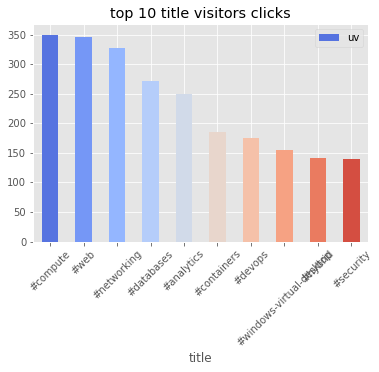

In [26]:

## top 10 title visitors clicks 
fig=plt.figure(figsize=(10,10))
title_clicks[:10].loc[:,['title','uv']].plot(x='title',y='uv',kind='bar',color=sns.color_palette('coolwarm',10))
plt.xticks(rotation=45)
plt.title("top 10 title visitors clicks")
plt.show()





In [86]:

## type of clicks for 4 urls
qry_comp_clicks="""
//top10 article clicks
let start=datetime(2020-03-30);
let end=datetime(2020-04-14);
database('CustomerTouchPoint').PageView
| where Site == 'docs.microsoft.com'
| where IsTest!=1 and enrich_url_pg_query_string !contains 'traffic-source=cats' | invoke cluster('Cgadataout').database('Publish').ApplyTechSitesBotFilters()
| invoke database('DevRelWorkArea').FilterDocsArea('AAC')
| where StartDateTime >= start and StartDateTime < end
| extend month=getmonth(StartDateTime)
| extend stem_url = extract('^http?s://docs.microsoft.com/([^/]*)/(.*)',2,Url)
| extend stem_url= replace(@'/index$', @'/', stem_url)
| where Url matches regex @'^https?://docs.microsoft.com/en-us/azure/architecture/browse/'  or  Url matches regex @'^https?://docs.microsoft.com/en-us/azure/architecture/architectures/'
| extend  referrerUrl=strcat( Referrer_uri_stem,ReferrerDomain)
| where LinkClickEvents ==1
//| where LinkClickEventsJson contains "content>body"
| mv-expand target_url_Json
| extend tar_stem_url = extract('^http?s://docs.microsoft.com/([^/]*)/(.*)',2,tostring(target_url_Json))
| extend tar_stem_url= replace(@'/index$', @'/', tar_stem_url)
| extend target_url=tostring(target_url_Json) 
| summarize link_arc=dcountif(PageViewId,LinkClickEventsJson contains "content>body",2),link_cat=dcountif(PageViewId,LinkClickEventsJson contains "#",2),
link_toc=dcountif(PageViewId,LinkClickEventsJson  contains "left toc",2),dcount(PageViewId,2) 
by stem_url
 """

response = kc.execute("DevRelWorkArea",qry_comp_clicks)
comp_clicks=pd.DataFrame(response.primary_results[0],columns=['url','clc_art','clc_cat','clc_toc','clc_all'])
comp_clicks.head(10)

,url,clc_art,clc_cat,clc_toc,clc_all
0,azure/architecture/browse/,2721,245,1886,5028
1,azure/architecture/architectures/,2870,157,978,4130
2,azure/architecture/architectures/reference-architectures,2505,5,937,3630
3,azure/architecture/architectures/example-workloads,871,24,388,1302


C:\Users\v-yuasun\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  from ipykernel import kernelapp as app


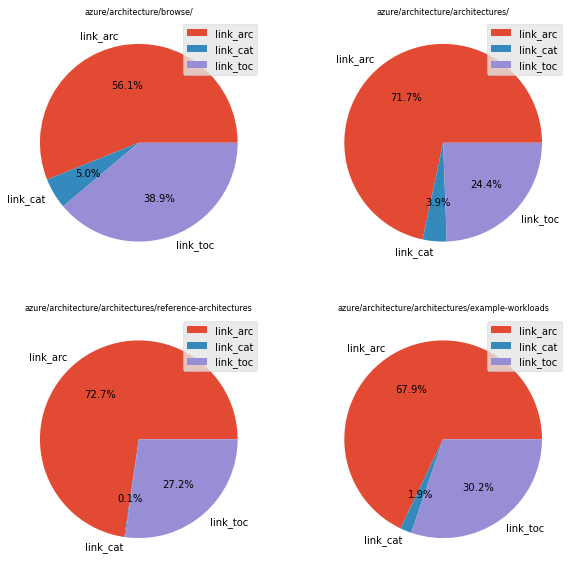

In [87]:

fig=plt.figure(figsize=(10,10))
#ax1=fig.add_subplot(141)
#ax2=fig.add_subplot(142)
#ax3=fig.add_subplot(143)
#ax4=fig.add_subplot(144)
plt.style.use('ggplot')
i=1
#plt.title("Share of cnt of Clicks for 4 Urls for Browse Page",fontsize=6)

url_ls=comp_clicks.url.unique()
for url in url_ls:
      tmp_subset=comp_clicks[comp_clicks.url==url]
      tmp_df=pd.DataFrame(np.array(comp_clicks[comp_clicks.url==url]).flatten()[1:4],index=['link_arc','link_cat','link_toc'],columns=["x"])
      ax=fig.add_subplot(2,2,i)
      ax.pie(tmp_df, autopct="%1.1f%%",labels=['link_arc','link_cat','link_toc'])
      ax.set_title(url,fontsize=8)
      ax.legend()
     # ax.add_artist(ax.Circle((0, 0), 0.65, color='white'))
      i+=1
#plt.gca().add_artist(plt.Circle((0, 0), 0.65, color='white'))
#plt.axis('equal')

#plt.title("Share of cnt of Clicks for 4 Urls for Browse Page")
plt.show()

      
      



In [29]:

## long term daily traffic
qry_daily_traf="""
let start=datetime(2019-01-01);
let end=datetime(2020-04-06);
database('CustomerTouchPoint').PageView
| where Site == 'docs.microsoft.com'
| where IsTest!=1 and enrich_url_pg_query_string !contains 'traffic-source=cats' | invoke cluster('Cgadataout').database('Publish').ApplyTechSitesBotFilters()
| invoke database('DevRelWorkArea').FilterDocsArea('AAC')
| where StartDateTime >= start and StartDateTime < end
| extend month=getmonth(StartDateTime)
| extend stem_url = extract('^http?s://docs.microsoft.com/([^/]*)/(.*)',2,Url)
| extend stem_url= replace(@'/index$', @'/', stem_url)
| where  Url matches regex @'^https?://docs.microsoft.com/en-us/azure/architecture/architectures/'
| summarize pv=dcount(PageViewId,2),uv=dcount(VisitorId,2) by day=startofday(StartDateTime)
 """
response = kc.execute("DevRelWorkArea",qry_daily_traf)
daily_traf=pd.DataFrame(response.primary_results[0],columns=['day','pv','uv'])
daily_traf.head(10)
daily_traf.day=pd.to_datetime(daily_traf.day)
daily_traf.info()
daily_traf.sort_values(by="day",inplace=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype                  
---  ------  --------------  -----                  
 0   day     110 non-null    datetime64[ns, tzutc()]
 1   pv      110 non-null    int64                  
 2   uv      110 non-null    int64                  
dtypes: datetime64[ns, tzutc()](1), int64(2)
memory usage: 2.7 KB


In [30]:
daily_traf=pd.DataFrame(response.primary_results[0],columns=['day','pv','uv'])

In [31]:
daily_traf.day=pd.to_datetime(daily_traf.day)
daily_traf.info()
daily_traf.sort_values(by="day",inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype                  
---  ------  --------------  -----                  
 0   day     110 non-null    datetime64[ns, tzutc()]
 1   pv      110 non-null    int64                  
 2   uv      110 non-null    int64                  
dtypes: datetime64[ns, tzutc()](1), int64(2)
memory usage: 2.7 KB


In [33]:
#ax.plot(daily_traf_subset.index,daily_traf_subset,label="daily  uv")
#ax.plot(daily_traf_subset.index,daily_traf_subset.rolling(7).mean(),label="weekly uv")

In [35]:
#daily_traf_subset=daily_traf_subset.reset_index()

In [38]:
daily_traf_subset.tail()

,day,uv
44,2020-04-01 00:00:00+00:00,1306
32,2020-04-02 00:00:00+00:00,1266
23,2020-04-03 00:00:00+00:00,1131
3,2020-04-04 00:00:00+00:00,505
47,2020-04-05 00:00:00+00:00,566


In [39]:
daily_traf_subset.tail(10)

,day,uv
62,2020-03-27 00:00:00+00:00,1095
66,2020-03-28 00:00:00+00:00,517
54,2020-03-29 00:00:00+00:00,578
51,2020-03-30 00:00:00+00:00,1377
1,2020-03-31 00:00:00+00:00,1408
44,2020-04-01 00:00:00+00:00,1306
32,2020-04-02 00:00:00+00:00,1266
23,2020-04-03 00:00:00+00:00,1131
3,2020-04-04 00:00:00+00:00,505
47,2020-04-05 00:00:00+00:00,566


In [41]:

## enagement compare
qry_eng="""
//engagement by urls
let start=datetime(2020-03-30);
let end=datetime(2020-04-14);
database('CustomerTouchPoint').PageView
| where Site == 'docs.microsoft.com'
| where IsTest!=1 and enrich_url_pg_query_string !contains 'traffic-source=cats' | invoke cluster('Cgadataout').database('Publish').ApplyTechSitesBotFilters()
| invoke database('DevRelWorkArea').FilterDocsArea('AAC')
| where StartDateTime >= start and StartDateTime < end
| extend month=getmonth(StartDateTime)
| extend stem_url = extract('^http?s://docs.microsoft.com/([^/]*)/(.*)',2,Url)
| extend stem_url= replace(@'/index$', @'/', stem_url)
| where Url matches regex @'^https?://docs.microsoft.com/en-us/azure/architecture/browse/' or  Url matches regex @'^https?://docs.microsoft.com/en-us/azure/architecture/architectures/'
| extend  referrerUrl=strcat( Referrer_uri_stem,ReferrerDomain)
| extend day=startofday(StartDateTime)
| summarize avg(ActivePageViewLength),percentile(ActivePageViewLength,50),avg(MaxScroll),
bounce_rate=dcountif(PageViewId,IsBounce,2)/todouble(dcount(PageViewId,2)) by stem_url 
 """

response = kc.execute("DevRelWorkArea",qry_eng)
eng=pd.DataFrame(response.primary_results[0],columns=['url','mean of pvl','median of pvl','max scroll','bounce_rate'])
eng.head(10)

,url,mean of pvl,median of pvl,max scroll,bounce_rate
0,azure/architecture/architectures/reference-architectures,181.564610,16,22.534488,0.105102
1,azure/architecture/architectures/,216.726306,17,13.482041,0.149459
2,azure/architecture/architectures/example-workloads,117.405927,12,24.857656,0.117409
3,azure/architecture/browse/,146.520350,19,23.111278,0.121657


In [42]:
eng.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   url            4 non-null      object 
 1   mean of pvl    4 non-null      float64
 2   median of pvl  4 non-null      int64  
 3   max scroll     4 non-null      float64
 4   bounce_rate    4 non-null      float64
dtypes: float64(3), int64(1), object(1)
memory usage: 288.0+ bytes


In [45]:
eng.head(10)

,Url,pvl,Max_Scroll
0,https://docs.microsoft.com/en-us/azure/architecture/browse/,9,0
1,https://docs.microsoft.com/en-us/azure/architecture/browse/,19,6
2,https://docs.microsoft.com/en-us/azure/architecture/browse/,13,0
3,https://docs.microsoft.com/en-us/azure/architecture/browse/,2,0
4,https://docs.microsoft.com/en-us/azure/architecture/browse/,422,55
5,https://docs.microsoft.com/en-us/azure/architecture/browse/,79,5
6,https://docs.microsoft.com/en-us/azure/architecture/browse/,131,90
7,https://docs.microsoft.com/en-us/azure/architecture/browse/,914,4
8,https://docs.microsoft.com/en-us/azure/architecture/browse/,2,0
9,https://docs.microsoft.com/en-us/azure/architecture/browse/,121,91


In [46]:
## take samples for pvl and max scroll 

qry_eng="""
//daily pv
let start=datetime(2019-01-01);
let end=datetime(2020-04-14);
database('CustomerTouchPoint').PageView
| where Site == 'docs.microsoft.com'
| where IsTest!=1 and enrich_url_pg_query_string !contains 'traffic-source=cats' | invoke cluster('Cgadataout').database('Publish').ApplyTechSitesBotFilters()
| invoke database('DevRelWorkArea').FilterDocsArea('AAC')
| where StartDateTime >= start and StartDateTime < end
| extend month=getmonth(StartDateTime)
| extend stem_url = extract('^http?s://docs.microsoft.com/([^/]*)/(.*)',2,Url)
| extend stem_url= replace(@'/index$', @'/', stem_url)
|  where Url matches regex @'^https?://docs.microsoft.com/en-us/azure/architecture/browse/'  or  Url matches regex @'^https?://docs.microsoft.com/en-us/azure/architecture/architectures/'
| project Url,ActivePageViewLength,MaxScroll
| take 500000
"""
response = kc.execute("DevRelWorkArea",qry_eng)
eng=pd.DataFrame(response.primary_results[0],columns=['Url','pvl','Max_Scroll'])
eng.head(10)
eng.Url=eng.Url.apply(lambda x:x[52:])

In [47]:
eng=eng[~eng.Url.isin(['https://docs.microsoft.com/en-us/azure/architecture/architectures/index','https://docs.microsoft.com/en-us/azure/architecture/architectures//'])]


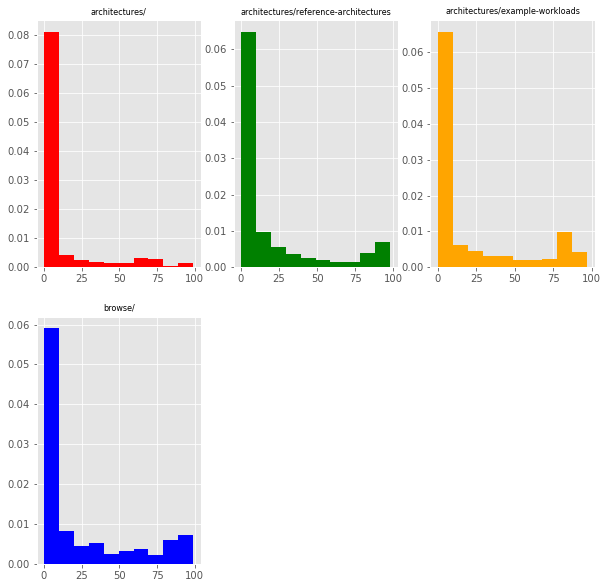

In [90]:
fig=plt.figure(figsize=(10,10))
#ax1=fig.add_subplot(141)
#ax2=fig.add_subplot(142)
#ax3=fig.add_subplot(143)
#ax4=fig.add_subplot(144)
plt.style.use('ggplot')
i=1
cols=['red','green','orange','blue']

url_ls=['architectures/','architectures/reference-architectures','architectures/example-workloads','browse/']
for url in url_ls:
    ax=fig.add_subplot(2,3,i)
    #print(i)
    tmp_subset=eng[eng.Url==url]
    ax.hist(tmp_subset['Max_Scroll'],bins=10,density=True,color=cols[i-1])
    ax.set_title(url,fontsize=8)
    i+=1
  #  print(i)

plt.show()



In [57]:
## centeral limit therpos to take samples

size=30
count=5000



eng_tmp=eng[eng.pvl<=3600]
eng_tmp=eng_tmp[eng_tmp.Url.isin(['architectures/','architectures/reference-architectures','architectures/example-workloads','browse/'])]
sam_pvl={}


for url in eng_tmp.Url.unique():
    sub=eng[eng.Url==url]
    tmp_ls=[]
    for i in range(count):
        mean_pvl=sub.pvl.sample(size,replace=True).mean()
        tmp_ls.append(mean_pvl)
    sam_pvl[url]=tmp_ls

    

df=pd.DataFrame(sam_pvl)
    


In [45]:

## boxplot for page view length
#cols=['red','green','orange','blue']

plt.figure(figsize=(10, 10))
plt.style.use('ggplot')

sns.boxplot(data=df)
plt.xticks(rotation=45,fontsize=8)
plt.xlabel('url',fontsize=16)
plt.title("Page View Length Distribution for 4 Urls")
plt.ylim(0,500)
plt.show()

NameError: name 'df' is not defined

<Figure size 720x720 with 0 Axes>